In [1]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import astropy.io.fits as pf
import warnings
from astropy.table import Table, vstack
warnings.filterwarnings('ignore')

In [261]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

### This notebook is for calculating the redshift completeness and the catastrophic failure rate of galaxies, including BGS, LRGs, and ELGs.

Definition -

Assumption: The truth tables are complete and correct for all objects with z(true).
That’s a reasonable approximation for all target classes except ELGs.

If you’re using DELTACHI2>cut to define wether a redshift is conclusive
in a 1000 sec exposure, then:

a = LRGs with 0.3 < z(true) <1.4, DELTACHI2>cut, and z_Redrock = z(true)

b = LRGs with 0.3 < z(true) <1.4, DELTACHI2<cut, and z(true)<1.4

c = LRGs with 0.3 < z(true) <1.4, DELTACHI2>cut, and |z_Redrock - z(true)| > 1000 km/s

### Redshift completeness = $\frac{a}{a+b+c}$

### catastrophic failure rate = $\frac{c}{a+b+c}$


In [527]:
def get_deep_and_short_catalog(catalog, object_type):
    if object_type=='LRG':
        search_deep = np.where((catalog['subset']!='all')  & 
                               (catalog['subset']=='deep') & 
                               (catalog['EFFTIME_DARK']>3000) &
                               (catalog['TARGETS']!='BGS+MWS'))        
    
        search_short = np.where((all_catalog['subset']!='all') & 
                                (all_catalog['subset']!='deep') & 
                                (all_catalog['TARGETS']!='BGS+MWS') & 
                                (all_catalog['EFFTIME_DARK']>850) & 
                                (all_catalog['EFFTIME_DARK']<950))
    elif object_type=='LRG_VI':
        search_deep = np.where((catalog['subset']!='all')  & 
                               (catalog['subset']=='deep') & 
                               (catalog['N_VI']>0) &
                               (catalog['TARGETS']!='BGS+MWS'))        
    
        search_short = np.where((all_catalog['subset']!='all') & 
                                (all_catalog['subset']!='deep') & 
                                (all_catalog['TARGETS']!='BGS+MWS') & 
                                (all_catalog['EFFTIME_DARK']>850) & 
                                (all_catalog['EFFTIME_DARK']<950))
    elif object_type=='BGS':
        search_deep = np.where((catalog['subset']!='all')  & 
                               (catalog['subset']=='deep') & 
                               (catalog['EFFTIME_BRIGHT']>600))        
    
        search_short = np.where((all_catalog['subset']!='all') & 
                                (all_catalog['subset']!='deep') & 
                                (all_catalog['EFFTIME_DARK']>150) & 
                                (all_catalog['EFFTIME_DARK']<200))
    catalog_short = catalog[search_short[0]].copy()
    catalog_deep = catalog[search_deep[0]].copy()
    print('Number of spectra in deep:', len(catalog_deep))
    print('Number of spectra in short:', len(catalog_short))
    return catalog_deep, catalog_short

In [528]:
def matching_short_deep_information(catalog_deep, catalog_short,object_type):
    if object_type=='LRG':
        new_catalog_short = catalog_short[['TARGETID','Z','ZERR','TILEID','EFFTIME_DARK','DELTACHI2','ZWARN','FIBER']].to_pandas()
        new_catalog = catalog_deep['TARGETID','Z','TILEID','DELTACHI2','FIBERFLUX_Z','FLUX_W1','FLUX_R','FLUX_Z','FLUX_G','EBV','ZWARN','FIBER'].to_pandas()
        new_catalog['zmag']=-2.5*np.log10(new_catalog['FLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['gmag']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
        new_catalog['rmag']=-2.5*np.log10(new_catalog['FLUX_R'])+22.5-2.165*new_catalog['EBV']
        new_catalog['w1mag']=-2.5*np.log10(new_catalog['FLUX_W1'])+22.5-0.184*new_catalog['EBV']
        new_catalog['zfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['best_z']=new_catalog['Z']
        new_catalog['best_quality']=0
        new_catalog['best_quality'][(new_catalog['best_z']<1.4)  & (new_catalog['DELTACHI2']>30)]=4
        # here I assign LRG with z<1.4 and DELTACHI2>30 from the deep exposure as reliable

    elif object_type=='LRG_VI':
        new_catalog_short = catalog_short[['TARGETID','Z','ZERR','TILEID','EFFTIME_DARK','DELTACHI2','ZWARN','FIBER']].to_pandas()
        new_catalog = catalog_deep['TARGETID','Z','TILEID','DELTACHI2','FIBERFLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_R','FLUX_Z','FLUX_G','EBV','ZWARN','FIBER','best_quality','best_z'].to_pandas()
        new_catalog['zmag']=-2.5*np.log10(new_catalog['FLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['gmag']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
        new_catalog['rmag']=-2.5*np.log10(new_catalog['FLUX_R'])+22.5-2.165*new_catalog['EBV']
        new_catalog['w1mag']=-2.5*np.log10(new_catalog['FLUX_W1'])+22.5-0.184*new_catalog['EBV']
        new_catalog['zfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']
        #new_catalog['best_z']=new_catalog['Z']
        #new_catalog['best_quality']=0
        new_catalog['best_quality'][(new_catalog['best_quality']>=2.5)]=4
        # here I assign LRG with z<1.4 and DELTACHI2>30 from the deep exposure as reliable

    elif object_type=='BGS':
        new_catalog_short = catalog_short[['TARGETID','Z','ZERR','TILEID','EFFTIME_DARK','DELTACHI2','ZWARN','FIBER']].to_pandas()
        new_catalog = catalog_deep['TARGETID','Z','TILEID','DELTACHI2','FIBERFLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_R','FLUX_Z','FLUX_G','EBV','ZWARN','FIBER','SPECTYPE'].to_pandas()
        new_catalog['zmag']=-2.5*np.log10(new_catalog['FLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['gmag']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
        new_catalog['rmag']=-2.5*np.log10(new_catalog['FLUX_R'])+22.5-2.165*new_catalog['EBV']
        new_catalog['w1mag']=-2.5*np.log10(new_catalog['FLUX_W1'])+22.5-0.184*new_catalog['EBV']
        new_catalog['zfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']
        new_catalog['rfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_R'])+22.5-2.165*new_catalog['EBV']
        new_catalog['color']=(new_catalog['zmag']-new_catalog['w1mag'])-1.2*(new_catalog['gmag']-new_catalog['rmag'])+1.2
        new_catalog['best_z']=new_catalog['Z']
        new_catalog['best_quality']=0
        new_catalog['best_quality'][(new_catalog['best_z']<1.1)  & (new_catalog['DELTACHI2']>15)]=4
        # here I assign BGS with z<1.1 and DELTACHI2>15 from the deep exposure as reliable
   
    catalog_match = new_catalog_short.merge(new_catalog,on='TARGETID',how='left',suffixes=("","_deep"))
    final_match_catalog = catalog_match[catalog_match['TILEID_deep']==catalog_match['TILEID']]
    final_match_catalog['dz']=abs(final_match_catalog['best_z']-final_match_catalog['Z'])/(1.+final_match_catalog['best_z'])
    print('Number of spectra in the matched catalog:',len(final_match_catalog))
    return final_match_catalog    

In [542]:
def calculating_redshift_completeness_and_failure_rate(catalog,object_type):
    if object_type=='LRG':

        DELTACHI2_limit = 15

        a = ((catalog['DELTACHI2']>DELTACHI2_limit) & 
            (catalog['dz']<0.0033) & 
            (catalog['best_quality']==4))

        b = ((catalog['DELTACHI2']<DELTACHI2_limit)
            )

        c = ((catalog['DELTACHI2']>DELTACHI2_limit) & 
            (catalog['dz']>0.0033) & 
            (catalog['best_quality']==4))

        d = ((catalog['DELTACHI2']>DELTACHI2_limit) & 
            (catalog['best_quality']!=4))

    elif object_type=='BGS':

        DELTACHI2_limit = 15

        a = ((catalog['DELTACHI2']>DELTACHI2_limit) & 
            (catalog['dz']<0.0033) & 
            (catalog['best_quality']==4))

        b = ((catalog['DELTACHI2']<DELTACHI2_limit)
            )

        c = ((catalog['DELTACHI2']>DELTACHI2_limit) & 
            (catalog['dz']>0.0033) & 
            (catalog['best_quality']==4))

        d = ((catalog['DELTACHI2']>DELTACHI2_limit) & 
            (catalog['best_quality']!=4))
                
    N_a = len(catalog[a])
    N_b = len(catalog[b])
    N_c = len(catalog[c])
    N_all = len(catalog)
    N_d = len(catalog[d])

    redshift_completeness = N_a*1.0 / (N_a+N_b+N_c)
    failure_rate = N_c*1.0 / (N_a+N_b+N_c)
    #print('Redshift completeness, catastrophic failure rate:',redshift_completeness,failure_rate)
    return redshift_completeness,failure_rate

In [530]:
def getting_completeness_and_failure_rate_as_a_function_of_magnitude(base_line_catalog,mode,mag_bin,magnitude_name):
    redshift_completeness_all = []
    redshift_failure_rate_all = []
    average_bin = []
    for i in range(0,len(mag_bin)-1):
        average_bin.append((mag_bin[i]+mag_bin[i+1])/2.)
        if mode=='differential':
            input_catalog = base_line_catalog[(base_line_catalog[magnitude_name]>mag_bin[i]) & (base_line_catalog[magnitude_name]<mag_bin[i+1])]
        elif mode=='cumulative':
            input_catalog = base_line_catalog[(base_line_catalog[magnitude_name]>mag_bin[0]) & (base_line_catalog[magnitude_name]<mag_bin[i+1])]

        redshift_completeness_tmp,redshift_failure_tmp = calculating_redshift_completeness_and_failure_rate(input_catalog,object_type)
        redshift_completeness_all.append(redshift_completeness_tmp)
        redshift_failure_rate_all.append(redshift_failure_tmp)
    return average_bin, redshift_completeness_all, redshift_failure_rate_all   

In [531]:
def plot_curve(base_line_catalog,base_line_catalog_SV3,mode,mag_bin,magnitude_name):
    x,y,z = getting_completeness_and_failure_rate_as_a_function_of_magnitude(base_line_catalog,mode,mag_bin,magnitude_name)
    x,y_SV3,z_SV3 = getting_completeness_and_failure_rate_as_a_function_of_magnitude(base_line_catalog_SV3,mode,mag_bin,magnitude_name)
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(x,np.array(y),label='SV1')
    plt.plot(x,np.array(y_SV3),label='SV3')
    plt.title('Redshift completeness')
    plt.legend()
    plt.xlabel(magnitude_name)
    #plt.axvline(21.72,ls='--',color='grey')
    #plt.text(19,0.85,mode,fontsize=15)
    plt.ylabel('Fraction ('+mode+')')

    plt.subplot(1,2,2)
    plt.title('Catastrophic failure rate')
    plt.plot(x,np.array(z))
    plt.plot(x,np.array(z_SV3))
    #plt.axvline(21.72,ls='--',color='grey')
    plt.xlabel(magnitude_name)

---------------------------------------------------------------------------------------------------
### LRGs


Using Cascades data release

In [532]:

object_type = 'LRG'
diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/LRG/'
#dataname = 'allVItiles_LRGzinfo_wVI.fits'
dataname = 'alltiles_LRGzinfo.fits'
all_catalog = Table.read(diretory+dataname)
catalog_deep, catalog_short = get_deep_and_short_catalog(all_catalog,object_type)

Number of spectra in deep: 24973
Number of spectra in short: 26045


In [533]:

final_catalog = matching_short_deep_information(catalog_deep, catalog_short,object_type)
# ---------------------
# cut the catalog with the interested parameter region  
# Baseline sample
# LRGs
#
#object_type='LRG'
selection = ((final_catalog['zfibermag']<21.72) &
             (final_catalog['best_z']>0.3) &
             (final_catalog['best_z']<1.1)
            ) 

base_line_catalog = final_catalog[selection]
SV3_selection = (((base_line_catalog['zmag']-base_line_catalog['w1mag'])>0.8*(base_line_catalog['rmag']-base_line_catalog['zmag'])-0.6) &
            ((((base_line_catalog['gmag']-base_line_catalog['rmag'])>1.34) & 
             (base_line_catalog['gmag']-base_line_catalog['rmag']>-1.55*(base_line_catalog['rmag']-base_line_catalog['w1mag'])+3.23)) |
            (base_line_catalog['rmag']-base_line_catalog['w1mag']>1.8)) &
            
             ((((base_line_catalog['rmag']-base_line_catalog['w1mag'])>(base_line_catalog['w1mag']-17.05)*1.83) & 
             ((base_line_catalog['rmag']-base_line_catalog['w1mag'])>(base_line_catalog['w1mag']-16.14))) |
            (base_line_catalog['rmag']-base_line_catalog['w1mag']>3.49))
            )
base_line_catalog_SV3 = base_line_catalog[SV3_selection]
print('Number of spectra in the baseline catalog:',len(base_line_catalog))

Number of spectra in the matched catalog: 24800
Number of spectra in the baseline catalog: 16009


zfibermag<21.72

a = LRGs with 0.3 < z(true) <1.1, DELTACHI2>cut, and z_Redrock = z(true)

b = LRGs with 0.3 < z(true) <1.1, DELTACHI2<cut, and z(true)<1.4

c = LRGs with 0.3 < z(true) <1.1, DELTACHI2>cut, and |z_Redrock - z(true)| > 1000 km/s

### Redshift completeness = $\frac{a}{a+b+c}$

### catastrophic failure rate = $\frac{c}{a+b+c}$

In [534]:
calculating_redshift_completeness_and_failure_rate(base_line_catalog,object_type)

(0.9343974960876369, 0.011205007824726134)

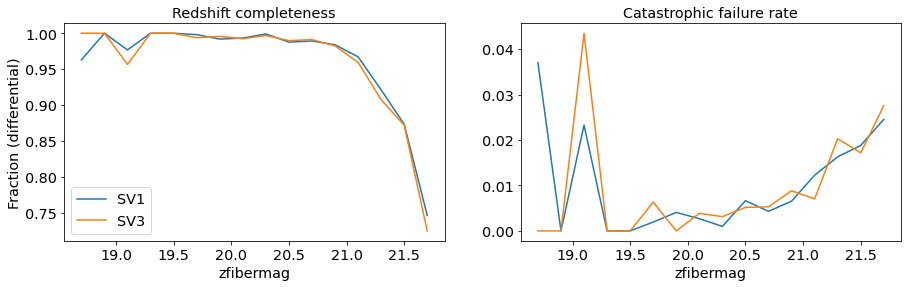

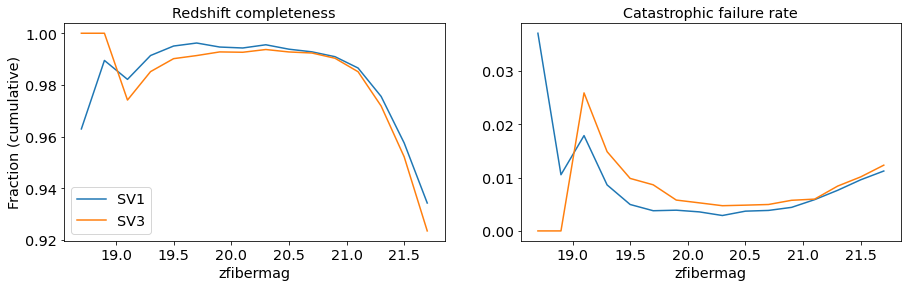

In [535]:
magnitude_name = 'zfibermag'
mode = 'differential'
mag_bin = np.arange(18.6,21.82,0.2)
plot_curve(base_line_catalog,base_line_catalog_SV3,mode,mag_bin,magnitude_name)
mode = 'cumulative'
plot_curve(base_line_catalog,base_line_catalog_SV3,mode,mag_bin,magnitude_name)

-------------------------------------------------------------------
### BGS

In [543]:
object_type ='BGS'

diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/BGS_ANY/'
dataname = 'alltiles_BGS_ANYzinfo.fits'
all_catalog = Table.read(diretory+dataname)
catalog_deep, catalog_short = get_deep_and_short_catalog(all_catalog,object_type)

Number of spectra in deep: 62967
Number of spectra in short: 203830


In [544]:
final_catalog = matching_short_deep_information(catalog_deep, catalog_short,object_type)
# ---------------------
# cut the catalog with the interested parameter region  
# Baseline sample
# LRGsb
#
#object_type='LRG'
selection = (#(final_catalog['rfibermag']<21.72) &
             (final_catalog['SPECTYPE']!=b'STAR') & 
             #(final_catalog['best_z']>0.0003) &
             (final_catalog['best_z']<0.5)
            ) 

base_line_catalog = final_catalog[selection]
SV3_selection = (((base_line_catalog['rfibermag']<20.75) & (base_line_catalog['color']<0)) | 
     ((base_line_catalog['rfibermag']<21.5) & (base_line_catalog['color']>=0)))

base_line_catalog_SV3 = base_line_catalog[SV3_selection]
print('Number of spectra in the baseline catalog:',len(base_line_catalog))

Number of spectra in the matched catalog: 136963
Number of spectra in the baseline catalog: 119485


a = BGS with  z(true) <0.5, DELTACHI2>cut, z_Redrock = z(true) & SPECTYPE!=STAR

b = BGS with  z(true) <0.5, DELTACHI2<cut, & SPECTYPE!=STAR

c = BGS with  z(true) <0.5, DELTACHI2>cut, |z_Redrock - z(true)| > 1000 km/s, & SPECTYPE!=STAR


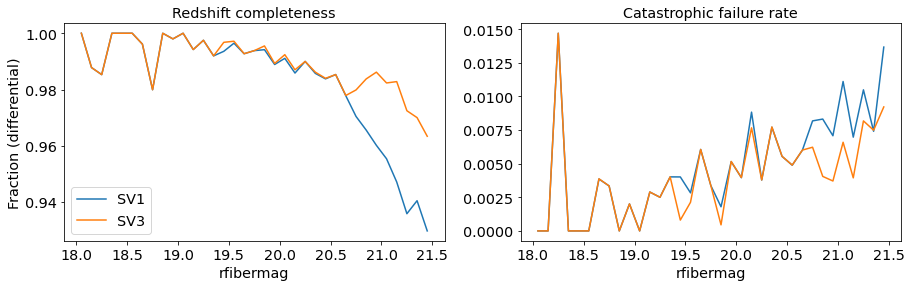

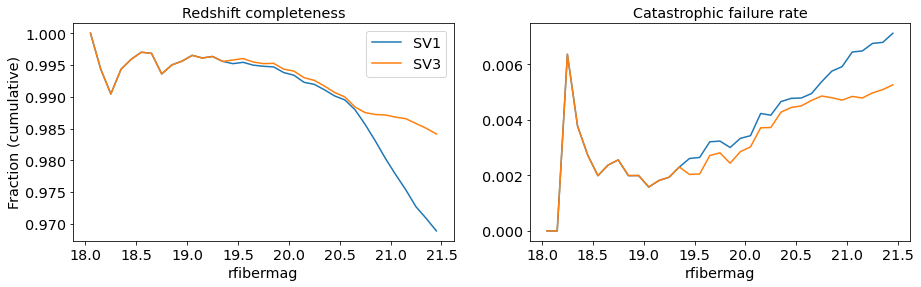

In [545]:
magnitude_name = 'rfibermag'
mode = 'differential'
mag_bin = np.arange(18.0,21.51,0.1)
plot_curve(base_line_catalog,base_line_catalog_SV3,mode,mag_bin,magnitude_name)
mode = 'cumulative'
plot_curve(base_line_catalog,base_line_catalog_SV3,mode,mag_bin,magnitude_name)